The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0
!pip install -U mxnet-cu101==1.7.0


# Deep Recurrent Neural Networks

:label:`sec_deep_rnn`

Up to now, we only discussed RNNs with a single unidirectional hidden layer.
In it the specific functional form of how latent variables and observations interact is rather arbitrary.
This is not a big problem as long as we have enough flexibility to model different types of interactions.
With a single layer, however, this can be quite challenging.
In the case of the linear models,
we fixed this problem by adding more layers.
Within RNNs this is a bit trickier, since we first need to decide how and where to add extra nonlinearity.

In fact,
we could stack multiple layers of RNNs on top of each other. This results in a flexible mechanism,
due to the combination of several simple layers. In particular, data might be relevant at different levels of the stack. For instance, we might want to keep high-level data about financial market conditions (bear or bull market) available, whereas at a lower level we only record shorter-term temporal dynamics.


Beyond all the above abstract discussion
it is probably easiest to understand the family of models we are interested in by reviewing :numref:`fig_deep_rnn`. It describes a deep RNN with $L$ hidden layers.
Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

![Architecture of a deep RNN.](../img/deep-rnn.svg)
:label:`fig_deep_rnn`

## Functional Dependencies

We can formalize the
functional dependencies
within the  deep architecture
of $L$ hidden layers
depicted in :numref:`fig_deep_rnn`.
Our following discussion focuses primarily on
the vanilla RNN model,
but it applies to other sequence models, too.

Suppose that we have a minibatch input
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$, number of inputs in each example: $d$) at time step $t$.
At the same time step,
let
the hidden state of the $l^\mathrm{th}$ hidden layer  ($l=1,\ldots,L$) be $\mathbf{H}_t^{(l)}  \in \mathbb{R}^{n \times h}$ (number of hidden units: $h$)
and
the output layer variable be $\mathbf{O}_t \in \mathbb{R}^{n \times q}$ (number of outputs: $q$).
Setting $\mathbf{H}_t^{(0)} = \mathbf{X}_t$,
the hidden state of
the $l^\mathrm{th}$ hidden layer
that uses the activation function $\phi_l$
is expressed as follows:

$$\mathbf{H}_t^{(l)} = \phi_l(\mathbf{H}_t^{(l-1)} \mathbf{W}_{xh}^{(l)} + \mathbf{H}_{t-1}^{(l)} \mathbf{W}_{hh}^{(l)}  + \mathbf{b}_h^{(l)}),$$
:eqlabel:`eq_deep_rnn_H`

where the weights $\mathbf{W}_{xh}^{(l)} \in \mathbb{R}^{h \times h}$ and $\mathbf{W}_{hh}^{(l)} \in \mathbb{R}^{h \times h}$, together with
the bias $\mathbf{b}_h^{(l)} \in \mathbb{R}^{1 \times h}$, are the model parameters of
the $l^\mathrm{th}$ hidden layer.

In the end,
the calculation of the output layer is only based on the hidden state of the final $L^\mathrm{th}$ hidden layer:

$$\mathbf{O}_t = \mathbf{H}_t^{(L)} \mathbf{W}_{hq} + \mathbf{b}_q,$$

where the weight $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ and the bias $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ are the model parameters of the output layer.

Just as with MLPs, the number of hidden layers $L$ and the number of hidden units $h$ are hyperparameters.
In other words, they can be tuned or specified by us.
In addition, we can easily
get a deep gated RNN
by replacing
the hidden state computation in
:eqref:`eq_deep_rnn_H`
with that from a GRU or an LSTM.


In [1]:
from mxnet import npx
from mxnet.gluon import rnn
from d2l import mxnet as d2l

npx.set_np()

## Implementation from Scratch

To implement a multi-layer RNN from scratch,
we can treat each layer as an `RNNScratch` instance
with its own learnable parameters.


In [2]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = [d2l.RNNScratch(num_inputs if i==0 else num_hiddens,
                                    num_hiddens, sigma)
                     for i in range(num_layers)]

The multi-layer forward computation
simply performs forward computation
layer by layer.


In [3]:
@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):
    outputs = inputs
    if Hs is None: Hs = [None] * len(inputs)
    for i in range(self.num_layers):
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
    return outputs, Hs

As an example, we train a deep GRU model on
*The Time Machine* dataset (same as in :numref:`sec_rnn-scratch`).
To keep things simple we set the number of layers to 2.


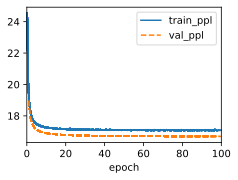

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),
                              num_hiddens=32, num_layers=2)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## Concise Implementation

Fortunately many of the logistical details required to implement multiple layers of an RNN are readily available in high-level APIs.
Our concise implementation will use such built-in functionalities.
The code generalizes the one we used previously in :numref:`sec_gru`,
allowing specification of the number of layers explicitly rather than picking the default of a single layer.


In [5]:
class GRU(d2l.RNN):  #@save
    def __init__(self, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = rnn.GRU(num_hiddens, num_layers, dropout=dropout)

The architectural decisions such as choosing hyperparameters are very similar to those of :numref:`sec_gru`.
We pick the same number of inputs and outputs as we have distinct tokens, i.e., `vocab_size`.
The number of hidden units is still 32.
The only difference is that we now (**select a nontrivial number of hidden layers by specifying the value of `num_layers`.**)


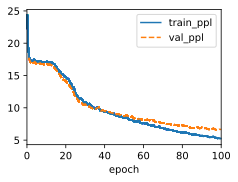

In [6]:
gru = GRU(num_hiddens=32, num_layers=2)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [7]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has i and and and and a'

## Summary

* In deep RNNs, the hidden state information is passed to the next time step of the current layer and the current time step of the next layer.
* There exist many different flavors of deep RNNs, such as LSTMs, GRUs, or vanilla RNNs. Conveniently these models are all available as parts of the high-level APIs of deep learning frameworks.
* Initialization of models requires care. Overall, deep RNNs require considerable amount of work (such as learning rate and clipping) to ensure proper convergence.

## Exercises

1. Replace the GRU by an LSTM and compare the accuracy and training speed.
1. Increase the training data to include multiple books. How low can you go on the perplexity scale?
1. Would you want to combine sources of different authors when modeling text? Why is this a good idea? What could go wrong?


[Discussions](https://discuss.d2l.ai/t/340)
